In [1]:
import numpy as np
import pandas as pd
from glob import glob as glob

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, QuantileTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVR

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('notebook')

# 1. Data Preparation

In [4]:
# Load target values and corresponding scaler
targets = pd.read_csv('datasets/targets.csv')
targets = targets.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
feature_transform = True

import joblib
scaler_targets = joblib.load('datasets/targets_scaler.pkl')

In [5]:
# Extract ID for train and test set
train_id = targets.index.values
sample_submission = pd.read_csv('sample_submission.csv')
test_id = np.unique(sample_submission.Id.str.split('_', expand=True)[0].astype('int'))

# 2. Modeling

In [6]:
def load_dataset(dataset_id, target):

    # Load dataset
    X_tr = pd.read_csv('datasets/%s_train.csv' % dataset_id)
    X_te = pd.read_csv('datasets/%s_test.csv' % dataset_id)

    # Specify target
    y = pd.read_csv('datasets/targets.csv')
    y = y.rename(columns={'Unnamed: 0': 'Id'}).set_index('Id')
    y_tr = y.iloc[X_tr.index][target]

    # Remove missing values
    missval = y_tr.isnull().values
    idx = ~missval
    X_tr = X_tr[idx]
    y_tr = y_tr[idx]
    print('Removing %s missing values from target dataset.' % missval.sum())
    
    return X_tr, X_te, y_tr, idx

In [7]:
# Create scorer function
from sklearn.metrics import make_scorer
def model_metric(y_true, y_pred, scaler=None, tidx=0):
    t_true = scaler.inverse_transform(np.transpose([y_true] * 5))[:, tidx]
    t_pred = scaler.inverse_transform(np.transpose([y_pred] * 5))[:, tidx]
    if tidx > 0:
        t_true = np.power(t_true, 1./1.5)
        t_pred = np.power(t_pred, 1./1.5)
    score = np.mean(np.sum(np.abs(t_true - t_pred), axis=0) / np.sum(t_true, axis=0))
    return score

In [8]:
def create_grid(model_metric, estimator=None, cv=5, scaler_targets=None, tidx=0):

    # Create Pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA()),
        ('estimator', estimator),
    ])

    # Define parameter grid
    Cs = np.logspace(-4.5, -2.5, 30)
    param_grid = [
    { 
        'scaler': [StandardScaler(),
                   RobustScaler(),
                   PowerTransformer()
                   ],
        'pca': [None, PCA(0.99)],
        'estimator__C': Cs,
        'estimator__loss': ['squared_epsilon_insensitive'], #['epsilon_insensitive', 'squared_epsilon_insensitive'],
    }
    ]

    # Create grid search object
    f_scorer = make_scorer(model_metric, greater_is_better=False, scaler=scaler_targets, tidx=tidx)
    grid = GridSearchCV(pipeline,
                        cv=cv,
                        param_grid=param_grid,
                        scoring=f_scorer,
                        return_train_score=True,
                        verbose=1,
                        n_jobs=-1)

    return grid

In [9]:
def extract_predictions(X_tr, X_te, grid, target, targets, truncate_top=5):

    # Store predictions in dictionary
    res = {}
    res['tr'] = grid.predict(X_tr)
    res['te'] = grid.predict(X_te)

    """
    # Assign age to correct bin
    if target == 'age':
        age_values = np.unique(targets.age)
        for t in ['tr', 'te']:
            age_pred_tr = res['%s' % t]
            for i, a in enumerate(age_pred_tr):
                age_pred_tr[i] = age_values[np.argmin(np.abs(a-age_values))]
    """
    # Put upper and lower ceiling on predictions
    pred_order = res['te'].argsort()
    res['te'][pred_order[:truncate_top]] = res['te'][pred_order[truncate_top]]
    res['te'][pred_order[-truncate_top:]] = res['te'][pred_order[-truncate_top]]

    print("Best: %f using %s" % (grid.best_score_, grid.best_params_))
    
    return res['tr'], res['te']

In [10]:
def plot_predictions(pred_tr, pred_te, y_tr):

    # Plot prediction descrepancy on training and test set
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

    sns.regplot(x=pred_tr, y=y_tr, marker='.', ax=ax[0])
    ax[0].set_title('Prediction X_tr: %s' % target)
    ax[0].set_xlim(ax[0].get_ylim())
    
    ax[1].plot(pred_te, '.', alpha=0.5)
    ax[1].plot(pred_tr, '.', alpha=0.3)
    ax[1].set_title('Prediction X_te: %s' % target)
    plt.show()

In [11]:
def create_df_pred(grid):

    # Store grid search parameters and outcomes in dataframe
    df_pred = pd.DataFrame(grid.cv_results_)
    columns = [c for c in df_pred.columns if 'time' not in c
               and 'split' not in c
               and 'rank' not in c
               and c!='params']
    df_pred = df_pred[columns].sort_values('mean_test_score', ascending=False)
    df_pred['param_scaler'] = df_pred['param_scaler'].astype('str')
    df_pred['param_pca'] = df_pred['param_pca'].astype('str')
    df_pred['param_estimator__C'] = df_pred['param_estimator__C'].astype('float')
    df_pred['param_estimator__loss'] = df_pred['param_estimator__loss'].astype('str')
    
    return df_pred

In [12]:
def plot_hyperparam_fitting(df_pred):

    # Plot the model fit information
    for p in df_pred['param_pca'].unique():
        for s in df_pred['param_scaler'].unique():
            for l in df_pred['param_estimator__loss'].unique():

                df_plot = df_pred[np.prod([df_pred['param_pca']==p,
                                           df_pred['param_scaler']==s,
                                           df_pred['param_estimator__loss']==l],
                                          axis=0).astype('bool')]
                df_plot = df_plot.sort_values('param_estimator__C')

                # Skip hyperparameter combination if not explored
                if df_plot.shape[0] == 0:
                    continue

                # Extract relevant modelling metrics
                train_scores = df_plot['mean_train_score']
                valid_scores = df_plot['mean_test_score']
                std_tr = df_plot['std_train_score']
                std_va = df_plot['std_test_score']

                plt.figure(figsize=(12, 4))
                alphas = df_plot['param_estimator__C']
                plt.semilogx(alphas, train_scores, label='Training Set')
                plt.semilogx(alphas, valid_scores, label='Validation Set')

                # Add marker and text for best score
                max_id = np.argmax(valid_scores)
                x_pos = alphas.iloc[max_id]
                y_pos = valid_scores.iloc[max_id]
                txt = '{:0.4f}'.format(y_pos)
                plt.scatter(x_pos, y_pos, marker='x', c='red', zorder=10)
                plt.text(x_pos, y_pos, txt, fontdict={'size': 18})

                # Quantify variance with ±std curves
                plt.fill_between(alphas, train_scores-std_tr, train_scores+std_tr, alpha=0.3)
                plt.fill_between(alphas, valid_scores-std_va, valid_scores+std_va, alpha=0.3)
                plt.ylabel('Performance metric')
                plt.xlabel('Model parameter')

                # Adjust x-lim, y-lim, add legend and adjust layout
                plt.legend()
                plt.title('%s\n%s\n%s' % (str(s), str(p), str(l)))
                plt.show()

In [13]:
def run_prediction(model_metric, dataset_id='merge', target='age', estimator=None, scaler_targets=None, tidx=0):
    
    # Extract dataset
    X_tr, X_te, y_tr, idx = load_dataset(dataset_id, target)
    print('Size of dataset: ', X_tr.shape)
    
    # Create grid search object
    grid = create_grid(model_metric, estimator=estimator, scaler_targets=scaler_targets, tidx=tidx)
    
    # Run grid search
    res = grid.fit(X_tr, y_tr)
    
    # Compute predictions
    pred_tr, pred_te = extract_predictions(X_tr, X_te, grid, target, targets)
    
    # Plot predictions
    plot_predictions(pred_tr, pred_te, y_tr)
    
    # Create prediction dataframe
    df_pred = create_df_pred(grid)
    
    # Plot prediction behaviour
    plot_hyperparam_fitting(df_pred)
    
    return df_pred, pred_tr, pred_te, grid, idx

In [14]:
def display_grid_optimization_details(grid):
    df_cv = pd.DataFrame(grid.cv_results_)
    selecter = df_cv.columns.str.contains('param_') + \
               df_cv.columns.str.contains('mean') + \
               df_cv.columns.str.contains('std')
    df_cv = df_cv.loc[:, selecter]
    df_cv = df_cv.loc[:, ~df_cv.columns.str.contains('_time')]
    display(df_cv.sort_values('mean_test_score', ascending=False)[:10])

In [15]:
def create_results_dataframe(predictions, scaler_targets, targets, test_id, feature_transform, res_type='_te'):

    # Collect results
    t_keys = [k for k in predictions.keys() if res_type in k]
    results = np.transpose([predictions[k] for k in t_keys])

    # Reset scaling
    results = scaler_targets.inverse_transform(results)

    # Store results in Dataframe
    if res_type=='_te':
        df_results = pd.DataFrame(results, columns=targets.columns)

    elif res_type=='_tr':
        # Get location of missing values
        miss_columns = [k for k in predictions.keys() if 'miss' in k]
        entries = np.transpose([predictions[k] for k in miss_columns])

        # Create dataframe and fill up missing value places with NaN
        df_results = pd.concat(
            [pd.Series(dict(zip(train_id[entries[:, c]].astype('str'), results[c])))
             for c in range(len(miss_columns))], axis=1)
        df_results.columns = targets.columns

    # Reset feature transformation
    if feature_transform:
        for col in df_results.columns[1:]:
            df_results[col] = np.power(df_results[col], 1./1.5)

    """
    # Assign age to correct bin
    age_values = np.unique(scaler_targets.inverse_transform(targets)[:, 0])
    for i, a in enumerate(df_results.age):
        df_results.age[i] = age_values[np.argmin(np.abs(a-age_values))]
    """

    # Add ID back to test results
    if res_type=='_te':
        df_results.insert(0, 'Id', test_id)
        df_results.set_index('Id', inplace=True)
    
    return df_results

In [16]:
def grids_summary(grids):

    grid_content = []
    for g in grids:

        column_name = []
        temp = []
        for k in g.best_params_:
            column_name.append(k)
            temp.append(g.best_params_[k])
        column_name.insert(0, 'score')
        temp.insert(0, -np.round(g.best_score_, 6))
        grid_content.append(temp)


    df_grid = pd.DataFrame(grid_content, columns=column_name)
    display(df_grid)

In [17]:
def save_results(predictions, scaler_targets, targets, test_id, feature_transform,
                 sample_submission, dataset_id, score_postfix):
    
    # Get results dataframe
    df_results_tr = create_results_dataframe(predictions, scaler_targets, targets,
                                             test_id, feature_transform, res_type='_tr')
    df_results_te = create_results_dataframe(predictions, scaler_targets, targets,
                                             test_id, feature_transform, res_type='_te')
    
    # Store test results in CSV file
    score_postfix = '_'.join(np.array(score_postfix).astype('str'))
    submission = sample_submission.copy()
    submission['Predicted'] = np.ravel(df_results_te)
    submission.to_csv('results/submission_svr-linear_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    
    # Store dataframes in CSV files
    df_results_tr.to_csv('results/results_tr_svr-linear_%s_%s.csv' % (dataset_id, score_postfix), index=False)
    df_results_te.to_csv('results/results_te_svr-linear_%s_%s.csv' % (dataset_id, score_postfix), index=False)

    return df_results_tr, df_results_te

In [18]:
def plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te):
    
    # Recreate original target dataset
    df_results = pd.DataFrame(scaler_targets.inverse_transform(targets),
                              columns=targets.columns)

    # Reset feature transformation
    if feature_transform:
        for col in df_results.columns[1:]:
            df_results[col] = np.power(df_results[col], 1./1.5)

    # Compare target distributions of train and test set
    for c in df_results.columns:
        plt.figure(figsize=(5, 5))
        plt.title(c)
        plt.hist(df_results[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_te[c], bins=25, alpha=0.5, density=True)
        plt.hist(df_results_tr[c], bins=25, alpha=0.5, density=True)
        plt.legend(['orig', 'test', 'train'])
        plt.show()

In [19]:
# Show list of available datasets
sorted(glob('datasets/*train.csv'))

['datasets/merge_train.csv', 'datasets/short_merge_train.csv']

Starting with dataset merge - target: age
Removing 0 missing values from target dataset.
Size of dataset:  (5865, 1405)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   11.1s
/home/mnotter/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 10.4min finished


Best: -0.144498 using {'estimator__C': 0.0010404983103657853, 'estimator__loss': 'squared_epsilon_insensitive', 'pca': None, 'scaler': RobustScaler()}


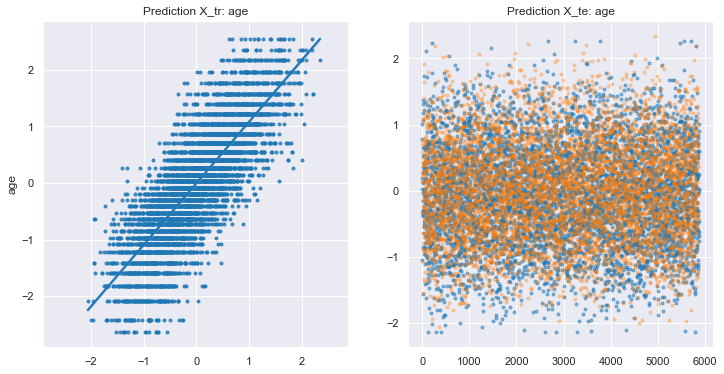

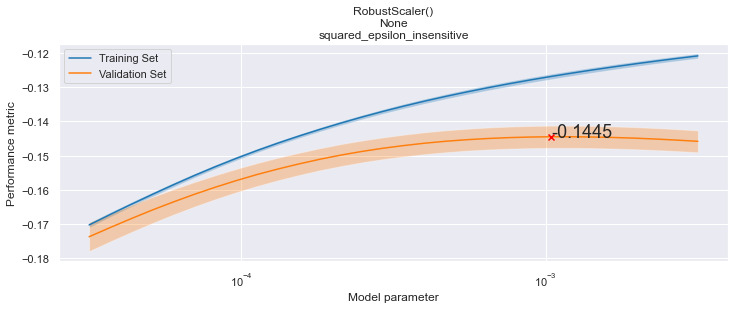

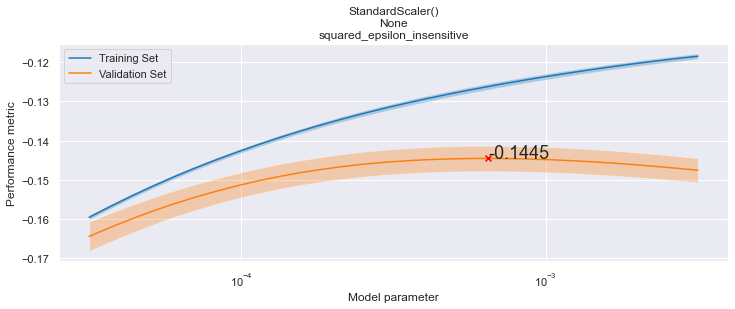

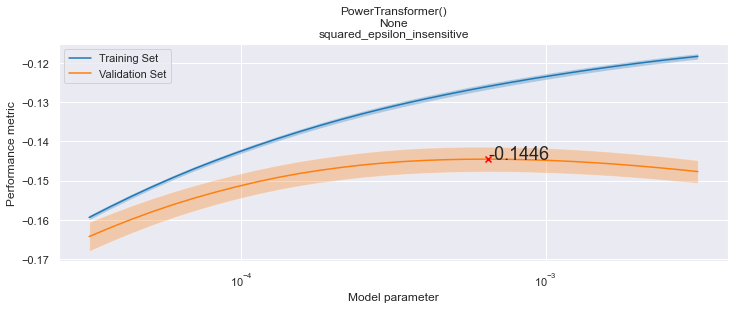

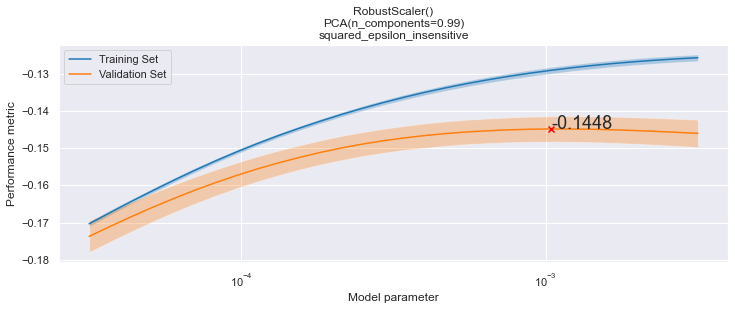

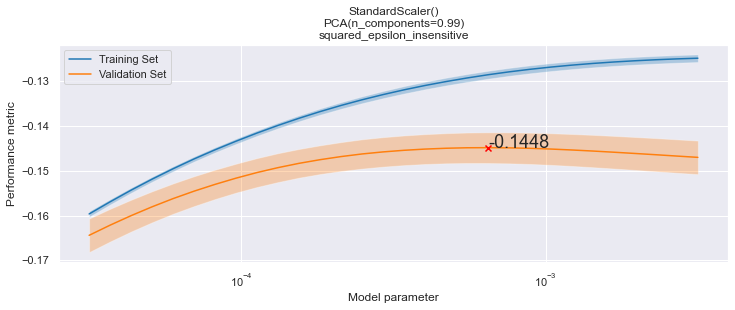

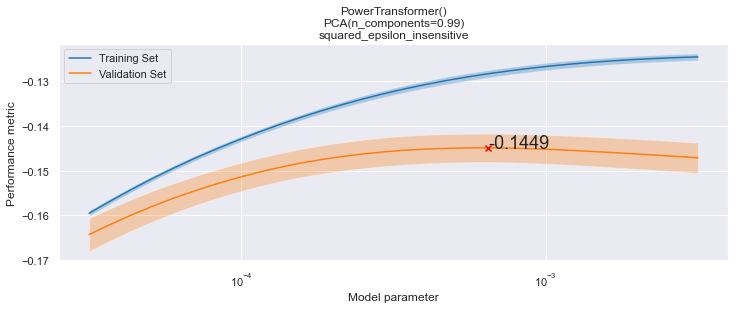

param_estimator__C        param_estimator__loss param_pca  \
133          0.0010405  squared_epsilon_insensitive      None   
139         0.00121957  squared_epsilon_insensitive      None   
114        0.000646167  squared_epsilon_insensitive      None   
108        0.000551289  squared_epsilon_insensitive      None   
116        0.000646167  squared_epsilon_insensitive      None   
120        0.000757374  squared_epsilon_insensitive      None   
110        0.000551289  squared_epsilon_insensitive      None   
145         0.00142946  squared_epsilon_insensitive      None   
127         0.00088772  squared_epsilon_insensitive      None   
122        0.000757374  squared_epsilon_insensitive      None   

           param_scaler  mean_test_score  std_test_score  mean_train_score  \
133      RobustScaler()        -0.144498        0.003232         -0.126904   
139      RobustScaler()        -0.144499        0.003232         -0.125918   
114    StandardScaler()        -0.144512        0.003248         -0.126195   
108    StandardScaler()        -0.144543        0.003248         -0.127204   
116  PowerTransformer()        -0.144551        0.003173         -0.126059   
120    StandardScaler()        -0.144562        0.003240         -0.125238   
110  PowerTransformer()        -0.144575        0.003189         -0.127066   
145      RobustScaler()        -0.144579        0.003232         -0.124979   
127      RobustScaler()        -0.144587        0.003228         -0.127939   
122  PowerTransformer()        -0.144596        0.003155         -0.125101   

     std_train_score  
133         0.000788  
139         0.000788  
114         0.000791  
108         0.000793  
116         0.000796  
120         0.000791  
110         0.000796  
145         0.000786  
127         0.000787  
122         0.000787

Starting with dataset merge - target: domain1_var1
Removing 437 missing values from target dataset.
Size of dataset:  (5428, 1405)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  8.1min
/home/mnotter/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  9.8min finished


Best: -0.152231 using {'estimator__C': 8.199608244604942e-05, 'estimator__loss': 'squared_epsilon_insensitive', 'pca': PCA(n_components=0.99), 'scaler': PowerTransformer()}


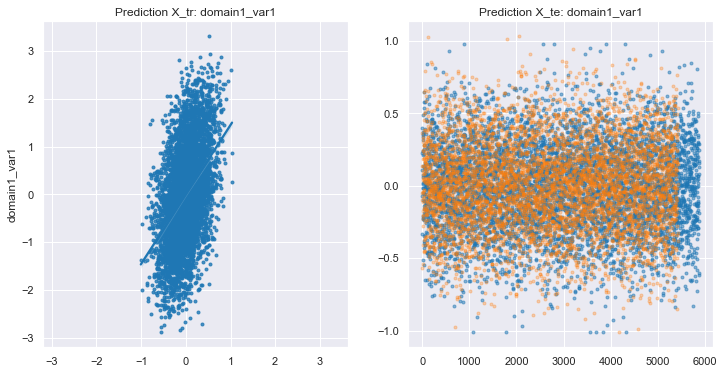

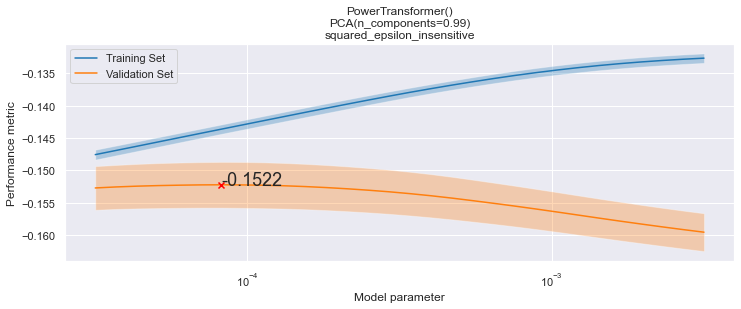

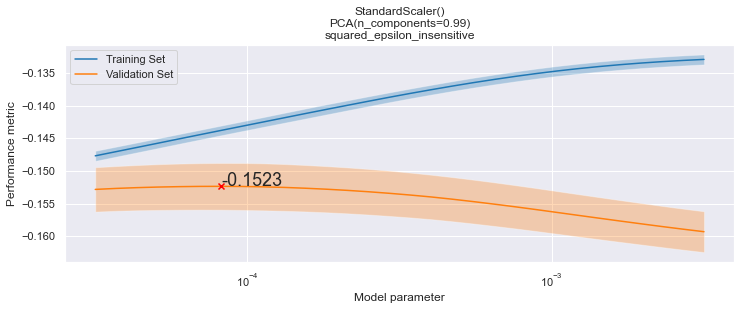

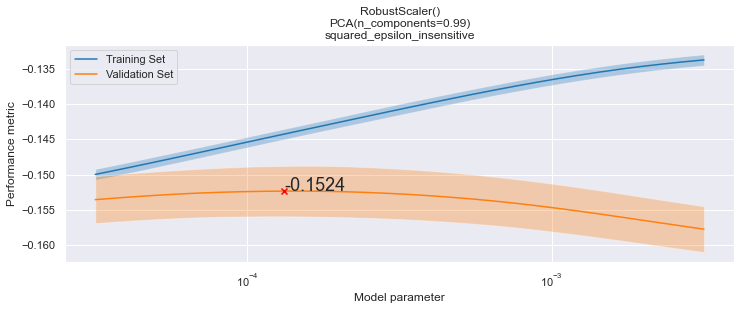

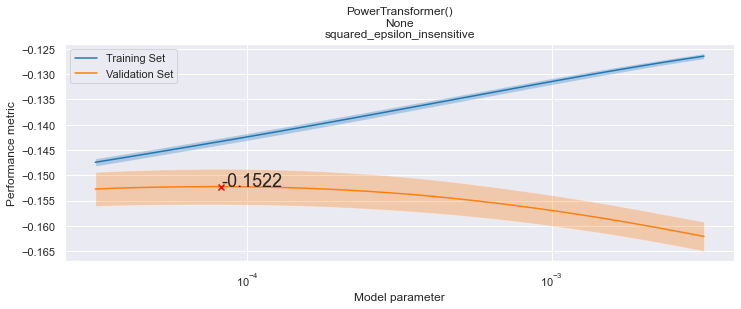

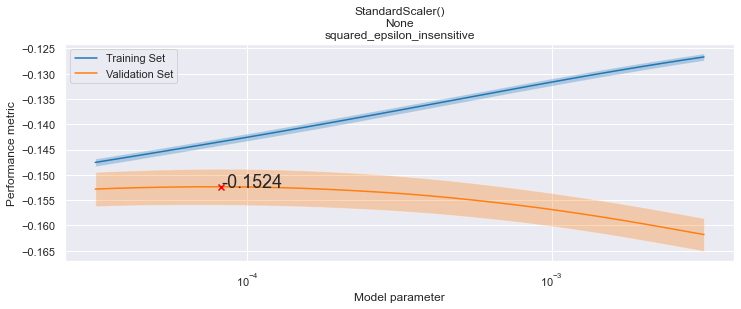

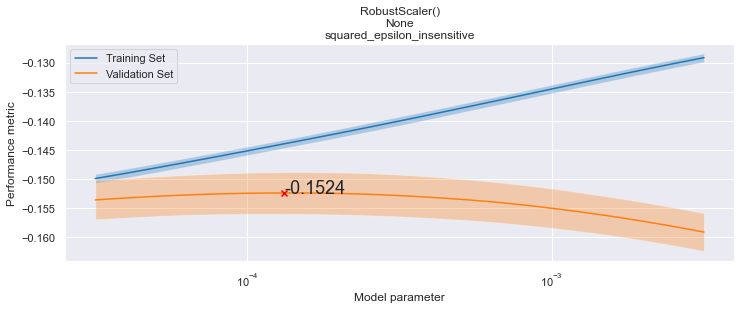

param_estimator__C        param_estimator__loss               param_pca  \
41        8.19961e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
38        8.19961e-05  squared_epsilon_insensitive                    None   
35        6.99564e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
47        9.61078e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
32        6.99564e-05  squared_epsilon_insensitive                    None   
44        9.61078e-05  squared_epsilon_insensitive                    None   
29        5.96846e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
26        5.96846e-05  squared_epsilon_insensitive                    None   
53        0.000112648  squared_epsilon_insensitive  PCA(n_components=0.99)   
39        8.19961e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   

          param_scaler  mean_test_score  std_test_score  mean_train_score  \
41  PowerTransformer()        -0.152231        0.003536         -0.143631   
38  PowerTransformer()        -0.152247        0.003536         -0.143301   
35  PowerTransformer()        -0.152249        0.003519         -0.144284   
47  PowerTransformer()        -0.152251        0.003545         -0.142978   
32  PowerTransformer()        -0.152258        0.003522         -0.144004   
44  PowerTransformer()        -0.152279        0.003544         -0.142592   
29  PowerTransformer()        -0.152294        0.003501         -0.144942   
26  PowerTransformer()        -0.152297        0.003505         -0.144703   
53  PowerTransformer()        -0.152303        0.003544         -0.142328   
39    StandardScaler()        -0.152341        0.003574         -0.143776   

    std_train_score  
41         0.000723  
38         0.000719  
35         0.000725  
47         0.000724  
32         0.000722  
44         0.000718  
29         0.000730  
26         0.000727  
53         0.000727  
39         0.000739

Starting with dataset merge - target: domain1_var2
Removing 437 missing values from target dataset.
Size of dataset:  (5428, 1405)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  9.8min finished


Best: -0.150634 using {'estimator__C': 3.1622776601683795e-05, 'estimator__loss': 'squared_epsilon_insensitive', 'pca': None, 'scaler': RobustScaler()}


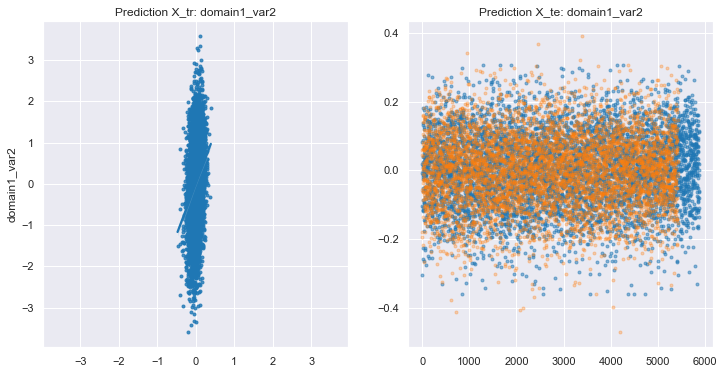

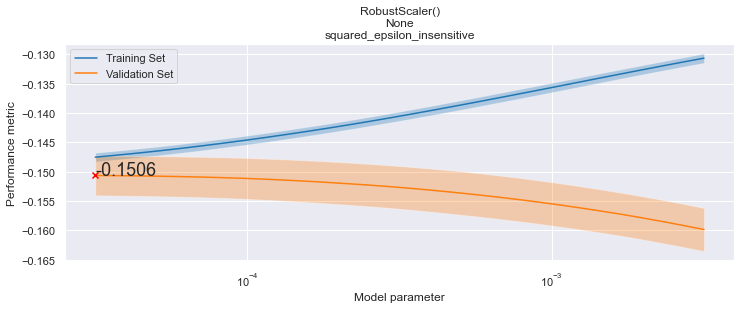

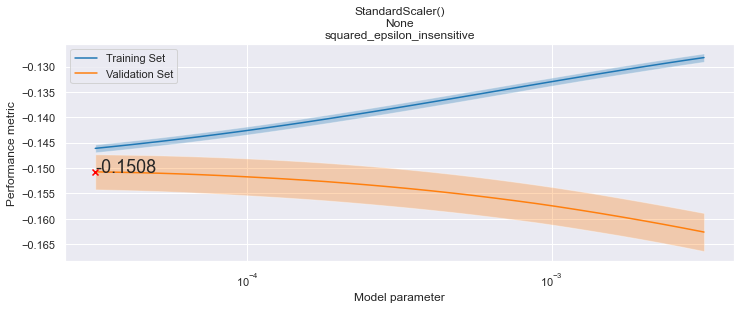

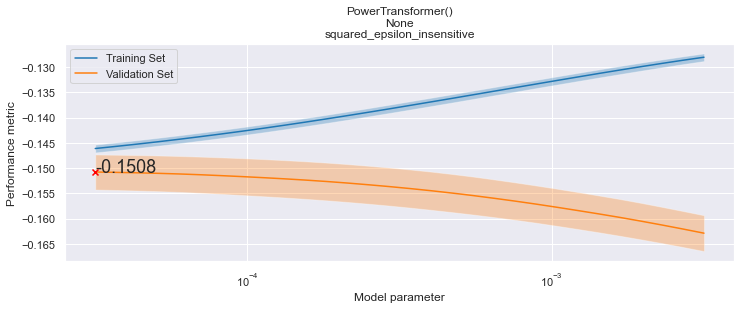

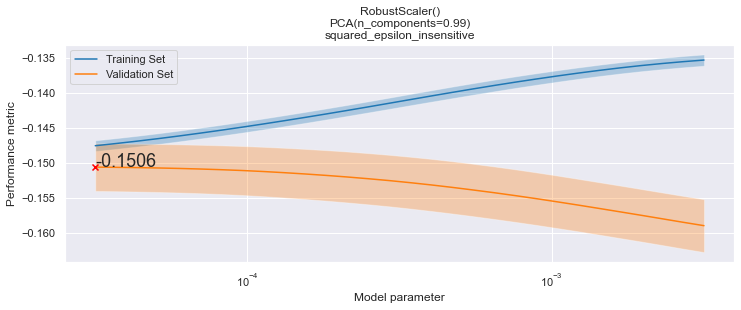

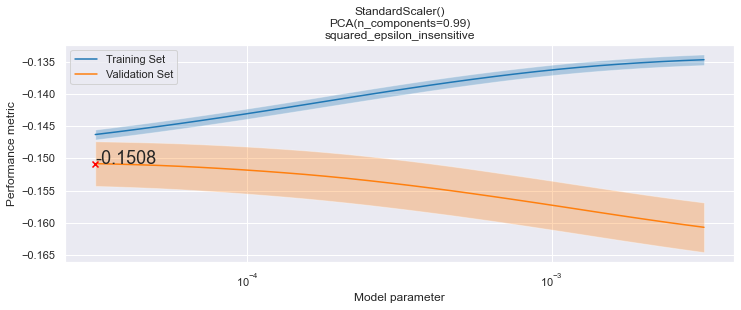

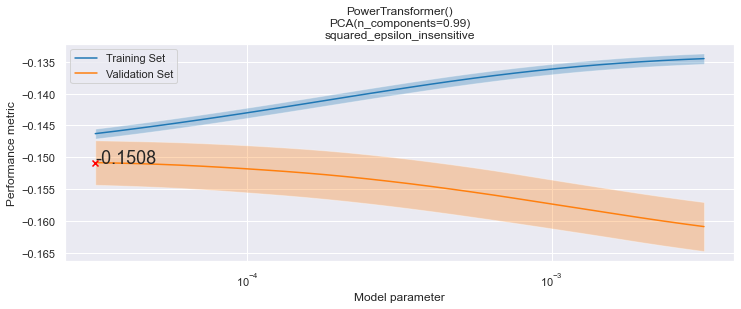

param_estimator__C        param_estimator__loss               param_pca  \
1         3.16228e-05  squared_epsilon_insensitive                    None   
4         3.16228e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
7         3.70651e-05  squared_epsilon_insensitive                    None   
10        3.70651e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
13        4.34441e-05  squared_epsilon_insensitive                    None   
16        4.34441e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
19         5.0921e-05  squared_epsilon_insensitive                    None   
22         5.0921e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
0         3.16228e-05  squared_epsilon_insensitive                    None   
2         3.16228e-05  squared_epsilon_insensitive                    None   

          param_scaler  mean_test_score  std_test_score  mean_train_score  \
1       RobustScaler()        -0.150634        0.003383         -0.147508   
4       RobustScaler()        -0.150638        0.003394         -0.147585   
7       RobustScaler()        -0.150663        0.003392         -0.147178   
10      RobustScaler()        -0.150668        0.003403         -0.147267   
13      RobustScaler()        -0.150703        0.003399         -0.146826   
16      RobustScaler()        -0.150709        0.003412         -0.146930   
19      RobustScaler()        -0.150754        0.003410         -0.146449   
22      RobustScaler()        -0.150761        0.003423         -0.146571   
0     StandardScaler()        -0.150780        0.003453         -0.146150   
2   PowerTransformer()        -0.150789        0.003469         -0.146133   

    std_train_score  
1          0.000766  
4          0.000767  
7          0.000762  
10         0.000764  
13         0.000760  
16         0.000763  
19         0.000760  
22         0.000764  
0          0.000768  
2          0.000773

Starting with dataset merge - target: domain2_var1
Removing 39 missing values from target dataset.
Size of dataset:  (5826, 1405)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 10.4min finished


Best: -0.182033 using {'estimator__C': 9.610779662375913e-05, 'estimator__loss': 'squared_epsilon_insensitive', 'pca': None, 'scaler': RobustScaler()}


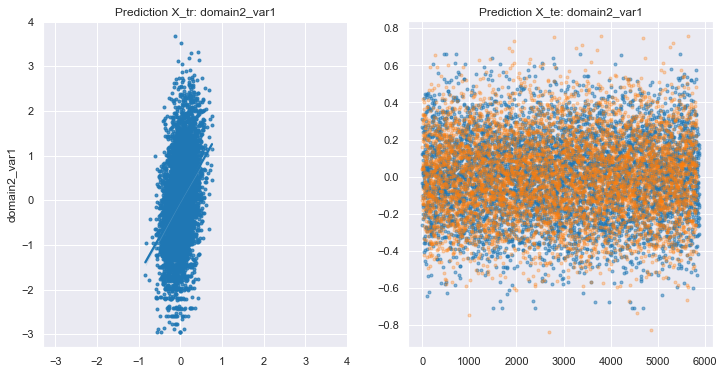

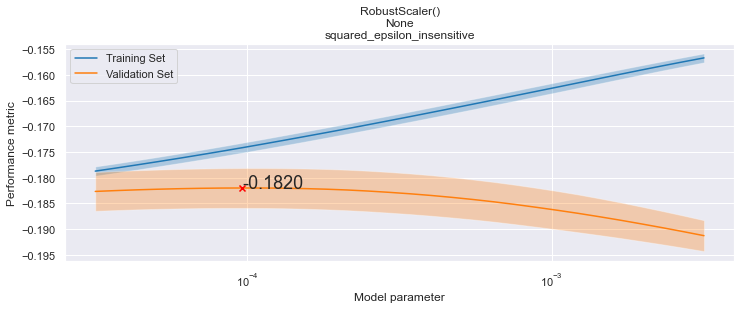

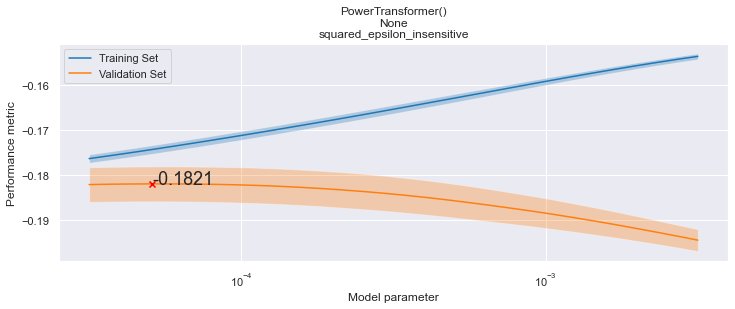

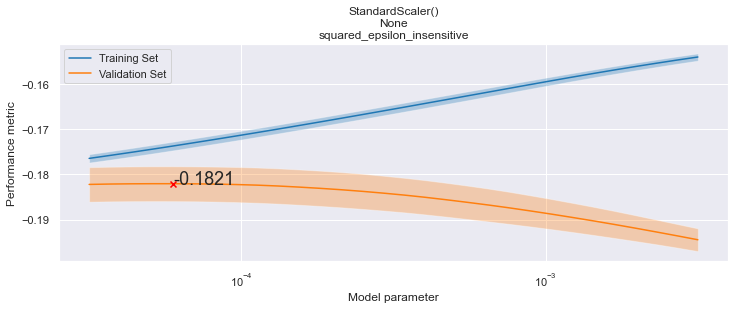

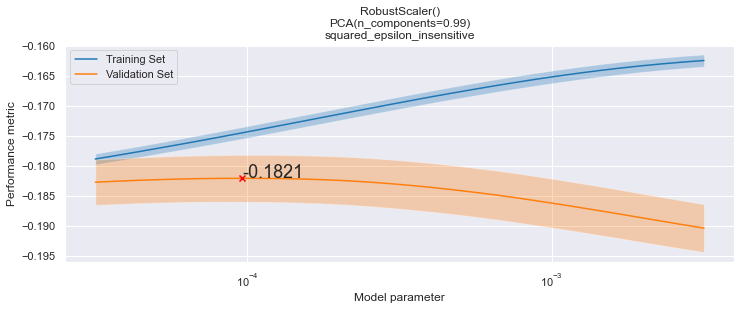

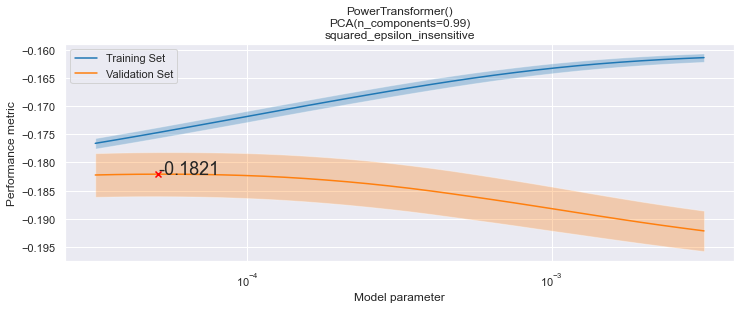

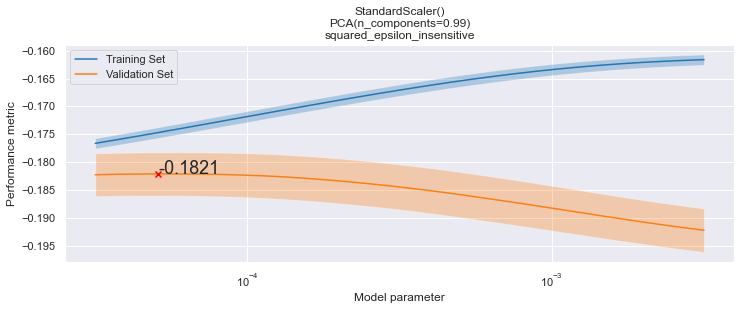

param_estimator__C        param_estimator__loss               param_pca  \
43        9.61078e-05  squared_epsilon_insensitive                    None   
49        0.000112648  squared_epsilon_insensitive                    None   
37        8.19961e-05  squared_epsilon_insensitive                    None   
20         5.0921e-05  squared_epsilon_insensitive                    None   
24        5.96846e-05  squared_epsilon_insensitive                    None   
18         5.0921e-05  squared_epsilon_insensitive                    None   
26        5.96846e-05  squared_epsilon_insensitive                    None   
46        9.61078e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
55        0.000132035  squared_epsilon_insensitive                    None   
52        0.000112648  squared_epsilon_insensitive  PCA(n_components=0.99)   

          param_scaler  mean_test_score  std_test_score  mean_train_score  \
43      RobustScaler()        -0.182033        0.003876         -0.174189   
49      RobustScaler()        -0.182038        0.003885         -0.173472   
37      RobustScaler()        -0.182050        0.003861         -0.174892   
20  PowerTransformer()        -0.182056        0.003876         -0.174414   
24    StandardScaler()        -0.182061        0.003855         -0.173705   
18    StandardScaler()        -0.182061        0.003849         -0.174417   
26  PowerTransformer()        -0.182062        0.003883         -0.173702   
46      RobustScaler()        -0.182068        0.003919         -0.174463   
55      RobustScaler()        -0.182076        0.003895         -0.172740   
52      RobustScaler()        -0.182078        0.003932         -0.173793   

    std_train_score  
43         0.000958  
49         0.000967  
37         0.000948  
20         0.000949  
24         0.000957  
18         0.000950  
26         0.000956  
46         0.000975  
55         0.000974  
52         0.000986

Starting with dataset merge - target: domain2_var2
Removing 39 missing values from target dataset.
Size of dataset:  (5826, 1405)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.8min
/home/mnotter/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  8.6min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 10.4min finished


Best: -0.175927 using {'estimator__C': 3.1622776601683795e-05, 'estimator__loss': 'squared_epsilon_insensitive', 'pca': PCA(n_components=0.99), 'scaler': PowerTransformer()}


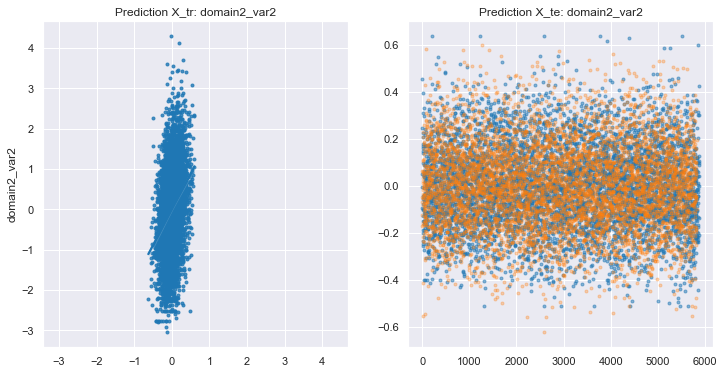

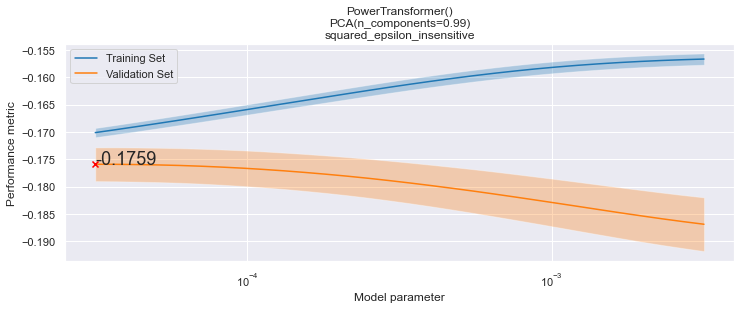

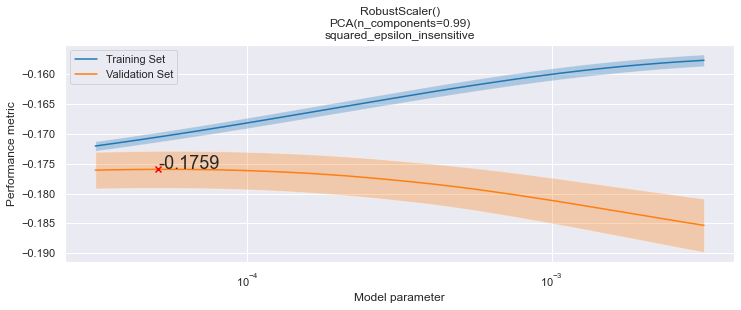

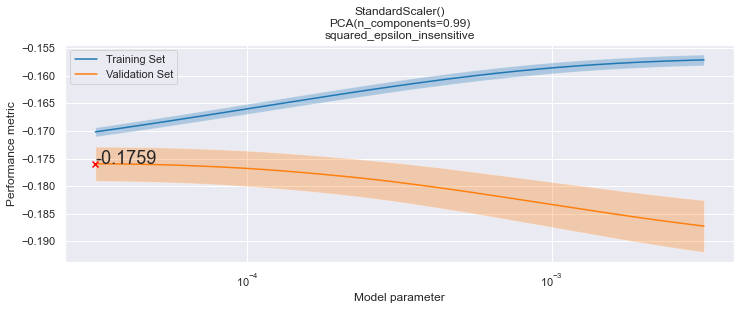

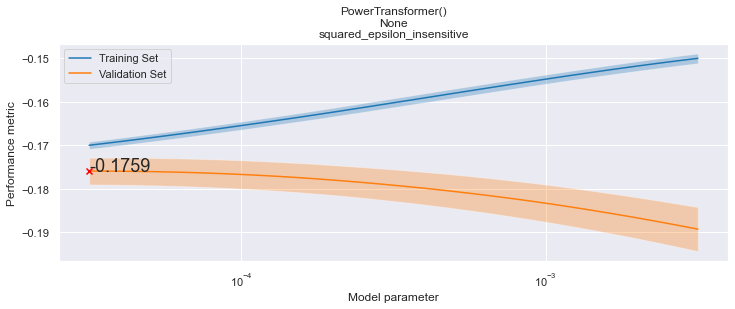

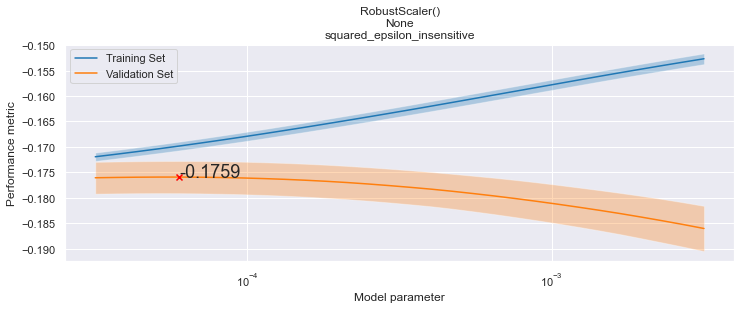

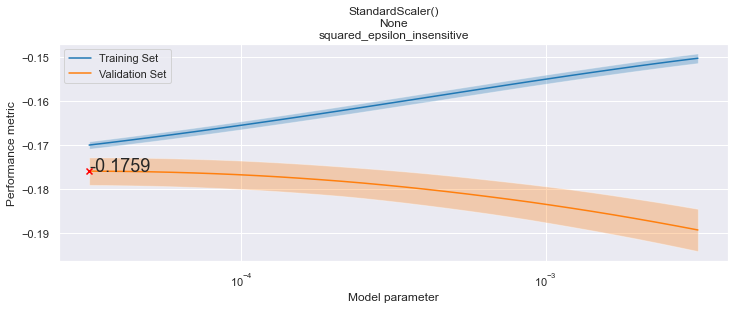

param_estimator__C        param_estimator__loss               param_pca  \
5         3.16228e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
25        5.96846e-05  squared_epsilon_insensitive                    None   
22         5.0921e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
19         5.0921e-05  squared_epsilon_insensitive                    None   
2         3.16228e-05  squared_epsilon_insensitive                    None   
28        5.96846e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
0         3.16228e-05  squared_epsilon_insensitive                    None   
3         3.16228e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
11        3.70651e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
8         3.70651e-05  squared_epsilon_insensitive                    None   

          param_scaler  mean_test_score  std_test_score  mean_train_score  \
5   PowerTransformer()        -0.175927        0.003078         -0.170138   
25      RobustScaler()        -0.175933        0.003161         -0.169831   
22      RobustScaler()        -0.175934        0.003101         -0.170513   
19      RobustScaler()        -0.175935        0.003149         -0.170387   
2   PowerTransformer()        -0.175937        0.003082         -0.169997   
28      RobustScaler()        -0.175937        0.003108         -0.169981   
0     StandardScaler()        -0.175941        0.003114         -0.170015   
3     StandardScaler()        -0.175941        0.003112         -0.170158   
11  PowerTransformer()        -0.175942        0.003099         -0.169590   
8   PowerTransformer()        -0.175954        0.003102         -0.169425   

    std_train_score  
5          0.000842  
25         0.000849  
22         0.000830  
19         0.000838  
2          0.000841  
28         0.000841  
0          0.000837  
3          0.000839  
11         0.000853  
8          0.000852

score  estimator__C              estimator__loss  \
0  0.144498      0.001040  squared_epsilon_insensitive   
1  0.152231      0.000082  squared_epsilon_insensitive   
2  0.150634      0.000032  squared_epsilon_insensitive   
3  0.182033      0.000096  squared_epsilon_insensitive   
4  0.175927      0.000032  squared_epsilon_insensitive   

                      pca              scaler  
0                    None      RobustScaler()  
1  PCA(n_components=0.99)  PowerTransformer()  
2                    None      RobustScaler()  
3                    None      RobustScaler()  
4  PCA(n_components=0.99)  PowerTransformer()

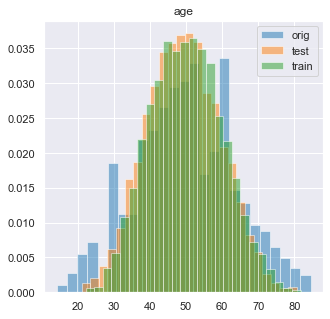

/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


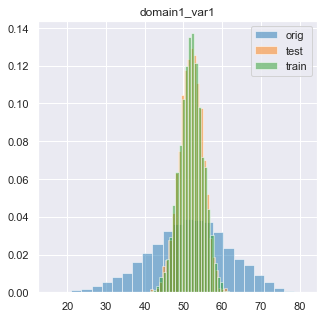

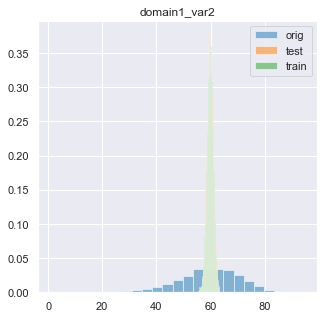

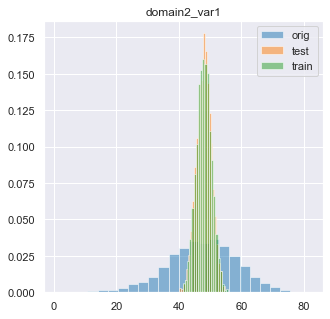

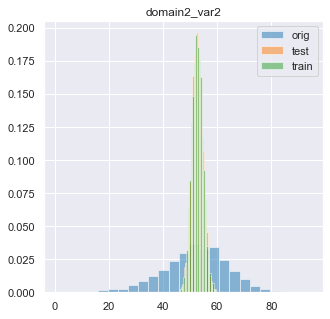

Score: 0.1590 | -0.1445 -0.1522 -0.1506 -0.1820 -0.1759


In [20]:
datasets_to_check = ['merge']

for dataset_id in datasets_to_check:

    predictions = {}
    scores = []
    grids = []

    for tidx, target in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):

        print('Starting with dataset %s - target: %s' % (dataset_id, target))
        estimator = LinearSVR()
        df_pred, pred_tr, pred_te, grid, idx = run_prediction(model_metric,
            dataset_id=dataset_id, target=target, estimator=estimator,
            scaler_targets=scaler_targets, tidx=tidx)
        
        display_grid_optimization_details(grid)

        predictions['%s_tr' % target] = pred_tr
        predictions['%s_te' % target] = pred_te
        predictions['%s_miss' % target] = idx
        
        scores.append(grid.best_score_)
        grids.append(grid)

    # Display grids summary
    grids_summary(grids)
    
    # Compute overall score
    weights = [.3, .175, .175, .175, .175]
    score = np.sum([-s * weights[i] for i, s in enumerate(scores)])
    score_postfix = [int(score*10000)] + [-int(s*10000) for i, s in enumerate(scores)]

    df_results_tr, df_results_te = save_results(
        predictions, scaler_targets, targets, test_id, feature_transform,
        sample_submission, dataset_id, score_postfix)

    plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te)
    
    # Feedback of overall score
    txt = 'Score: {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(score, *scores)
    print(txt)

Starting with dataset short_merge - target: age
Removing 0 missing values from target dataset.
Size of dataset:  (5825, 1655)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 13.2min finished


Best: -0.143927 using {'estimator__C': 0.0005512889788770672, 'estimator__loss': 'squared_epsilon_insensitive', 'pca': None, 'scaler': PowerTransformer()}


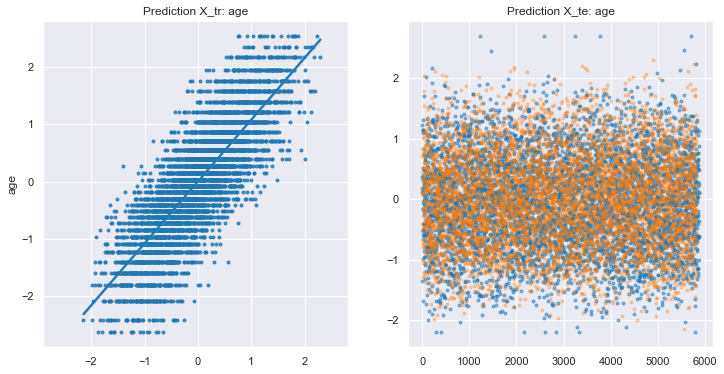

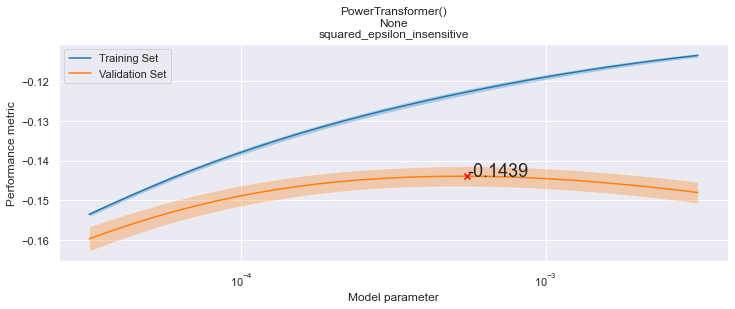

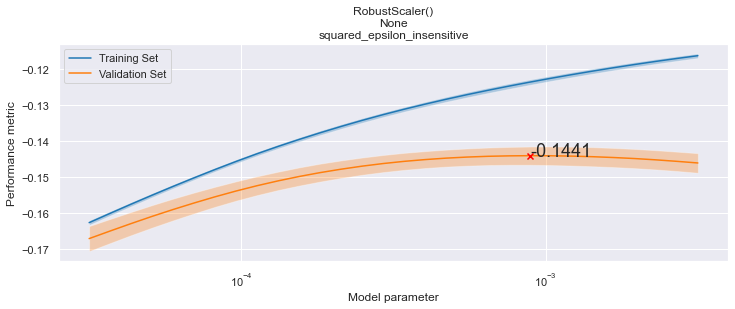

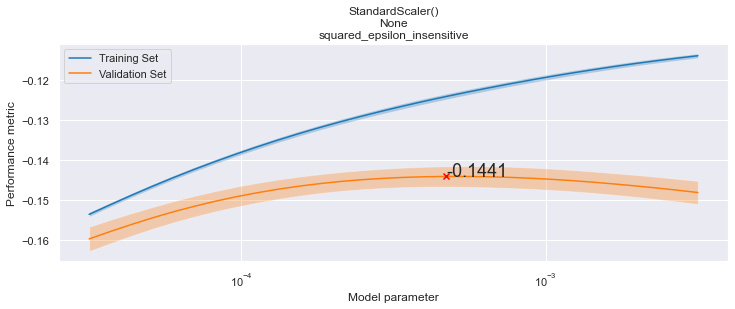

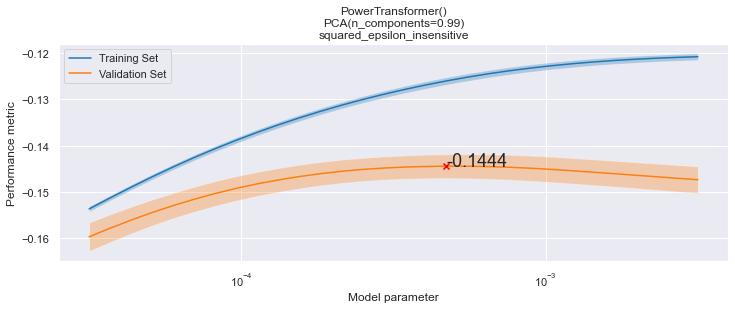

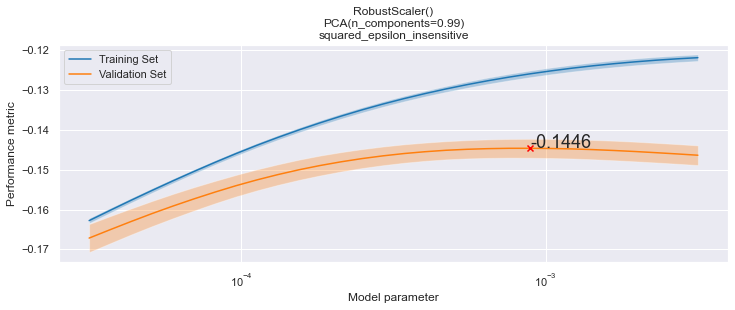

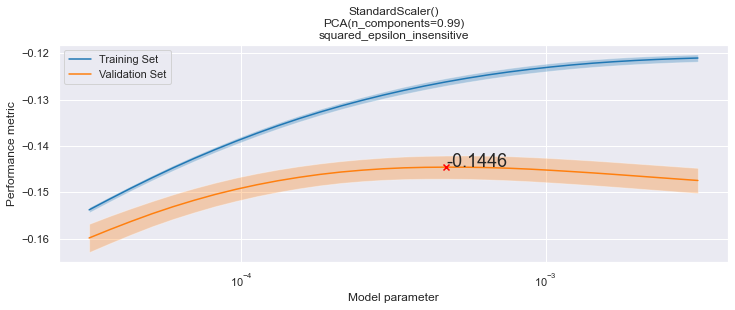

param_estimator__C        param_estimator__loss param_pca  \
110        0.000551289  squared_epsilon_insensitive      None   
104        0.000470342  squared_epsilon_insensitive      None   
116        0.000646167  squared_epsilon_insensitive      None   
98         0.000401281  squared_epsilon_insensitive      None   
127         0.00088772  squared_epsilon_insensitive      None   
122        0.000757374  squared_epsilon_insensitive      None   
102        0.000470342  squared_epsilon_insensitive      None   
108        0.000551289  squared_epsilon_insensitive      None   
133          0.0010405  squared_epsilon_insensitive      None   
121        0.000757374  squared_epsilon_insensitive      None   

           param_scaler  mean_test_score  std_test_score  mean_train_score  \
110  PowerTransformer()        -0.143927        0.002538         -0.122774   
104  PowerTransformer()        -0.143953        0.002513         -0.123882   
116  PowerTransformer()        -0.143982        0.002555         -0.121716   
98   PowerTransformer()        -0.144051        0.002479         -0.125039   
127      RobustScaler()        -0.144108        0.002533         -0.123634   
122  PowerTransformer()        -0.144116        0.002561         -0.120700   
102    StandardScaler()        -0.144122        0.002547         -0.124058   
108    StandardScaler()        -0.144129        0.002598         -0.122967   
133      RobustScaler()        -0.144134        0.002585         -0.122568   
121      RobustScaler()        -0.144161        0.002482         -0.124746   

     std_train_score  
110         0.000725  
104         0.000739  
116         0.000707  
98          0.000746  
127         0.000728  
122         0.000688  
102         0.000726  
108         0.000715  
133         0.000713  
121         0.000737

Starting with dataset short_merge - target: domain1_var1
Removing 435 missing values from target dataset.
Size of dataset:  (5390, 1655)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/mnotter/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 12.6min finished


Best: -0.150053 using {'estimator__C': 8.199608244604942e-05, 'estimator__loss': 'squared_epsilon_insensitive', 'pca': PCA(n_components=0.99), 'scaler': PowerTransformer()}


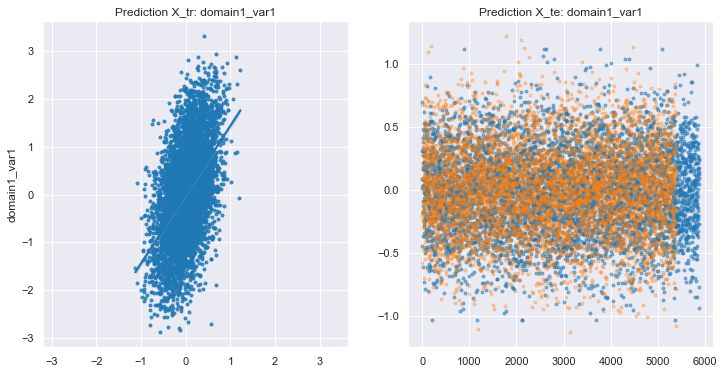

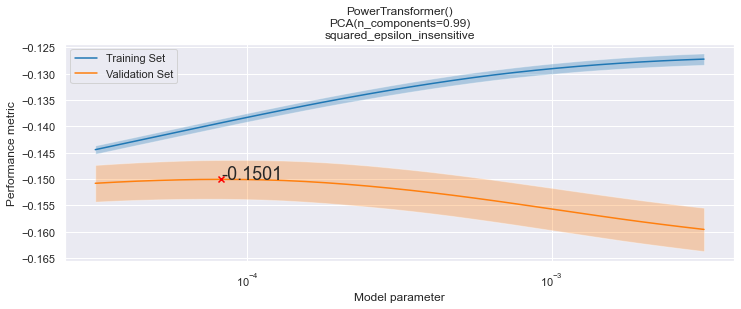

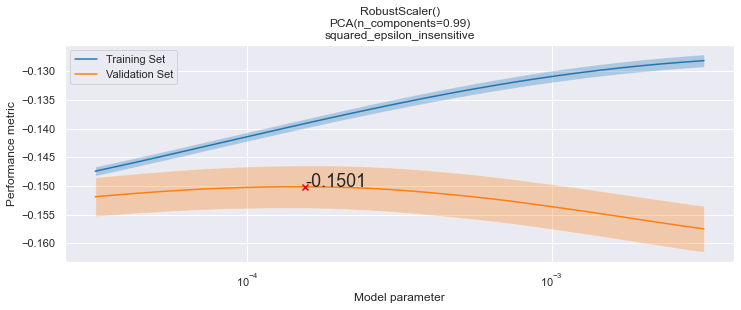

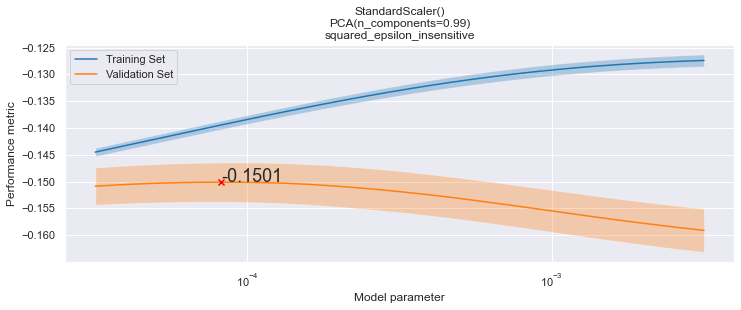

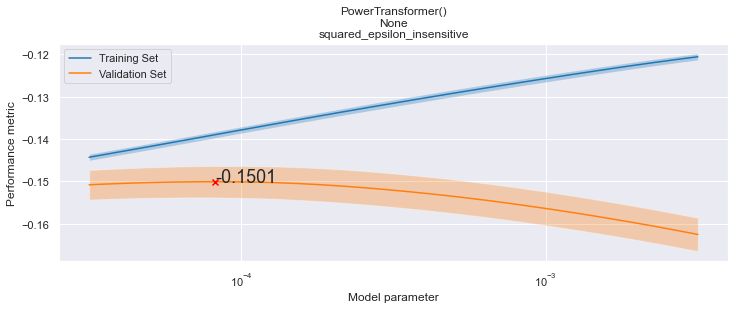

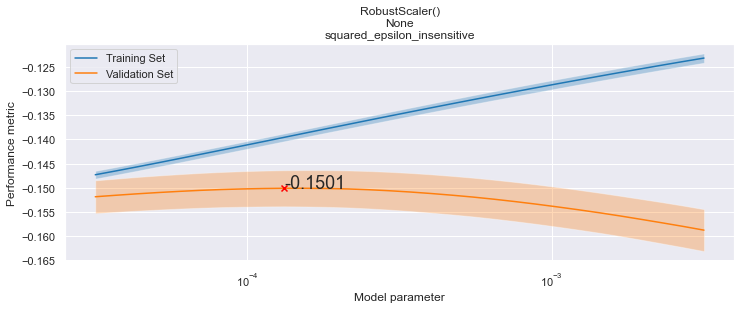

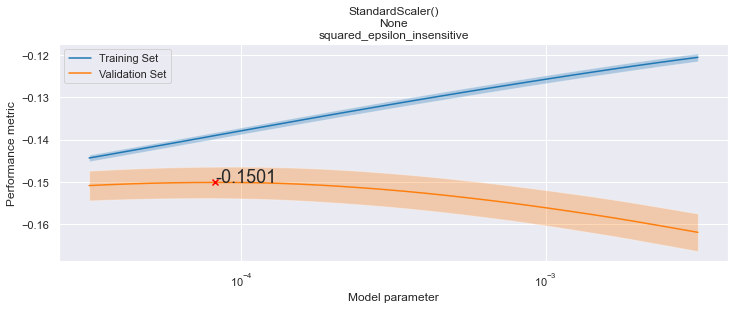

param_estimator__C        param_estimator__loss               param_pca  \
41        8.19961e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
38        8.19961e-05  squared_epsilon_insensitive                    None   
35        6.99564e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
47        9.61078e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
32        6.99564e-05  squared_epsilon_insensitive                    None   
55        0.000132035  squared_epsilon_insensitive                    None   
61        0.000154759  squared_epsilon_insensitive                    None   
44        9.61078e-05  squared_epsilon_insensitive                    None   
39        8.19961e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
36        8.19961e-05  squared_epsilon_insensitive                    None   

          param_scaler  mean_test_score  std_test_score  mean_train_score  \
41  PowerTransformer()        -0.150053        0.003681         -0.139327   
38  PowerTransformer()        -0.150060        0.003710         -0.138953   
35  PowerTransformer()        -0.150075        0.003655         -0.140171   
47  PowerTransformer()        -0.150078        0.003709         -0.138492   
32  PowerTransformer()        -0.150078        0.003682         -0.139854   
55      RobustScaler()        -0.150090        0.003723         -0.139564   
61      RobustScaler()        -0.150090        0.003755         -0.138678   
44  PowerTransformer()        -0.150091        0.003740         -0.138054   
39    StandardScaler()        -0.150098        0.003658         -0.139439   
36    StandardScaler()        -0.150100        0.003697         -0.139060   

    std_train_score  
41         0.000800  
38         0.000786  
35         0.000801  
47         0.000807  
32         0.000788  
55         0.000799  
61         0.000802  
44         0.000787  
39         0.000805  
36         0.000799

Starting with dataset short_merge - target: domain1_var2
Removing 435 missing values from target dataset.
Size of dataset:  (5390, 1655)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.2s
/home/mnotter/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 10.4min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 12.5min finished


Best: -0.147735 using {'estimator__C': 0.00011264816923358867, 'estimator__loss': 'squared_epsilon_insensitive', 'pca': None, 'scaler': RobustScaler()}


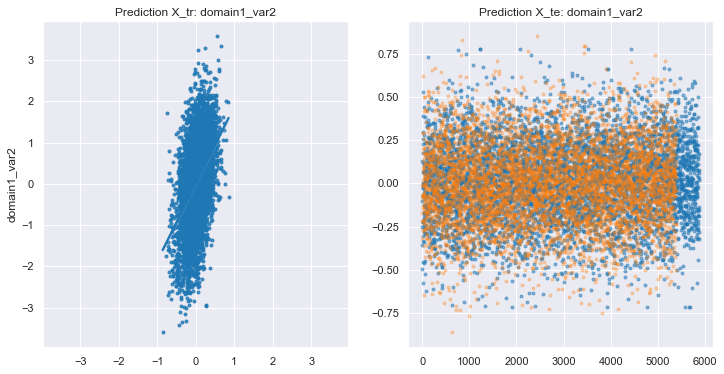

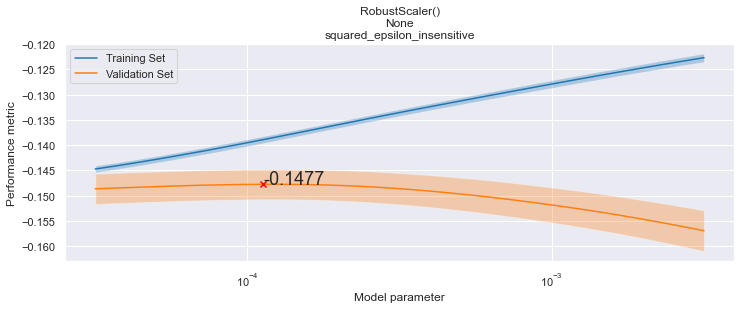

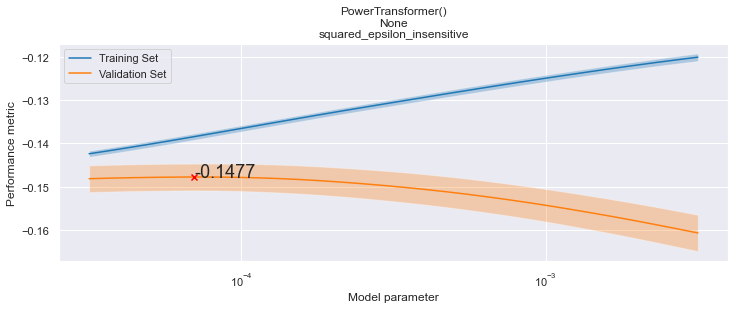

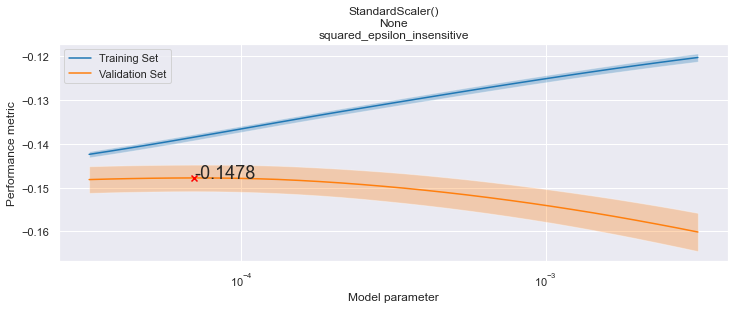

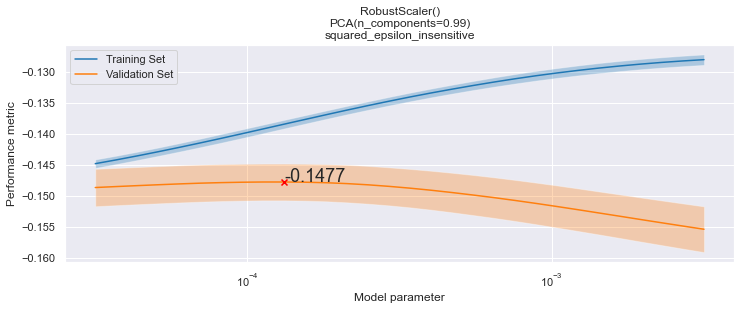

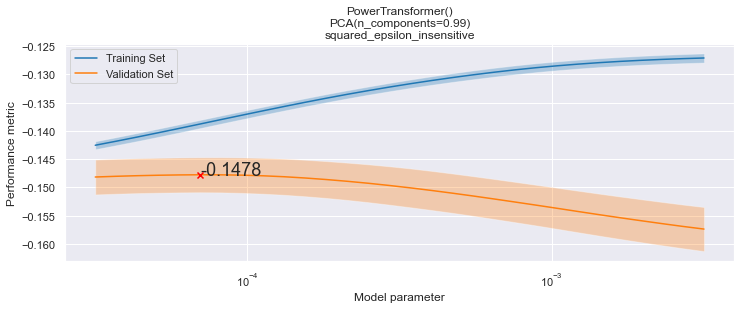

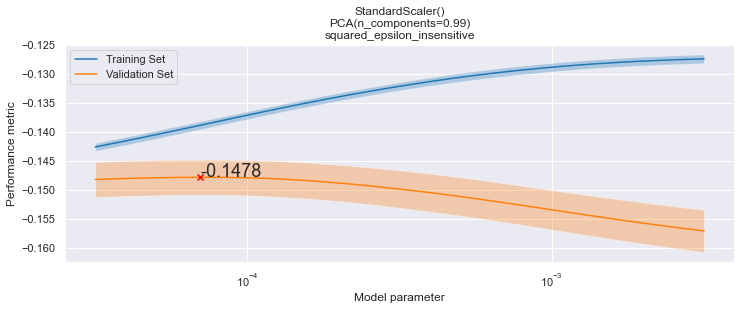

param_estimator__C        param_estimator__loss               param_pca  \
49        0.000112648  squared_epsilon_insensitive                    None   
55        0.000132035  squared_epsilon_insensitive                    None   
58        0.000132035  squared_epsilon_insensitive  PCA(n_components=0.99)   
52        0.000112648  squared_epsilon_insensitive  PCA(n_components=0.99)   
32        6.99564e-05  squared_epsilon_insensitive                    None   
35        6.99564e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
38        8.19961e-05  squared_epsilon_insensitive                    None   
41        8.19961e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
26        5.96846e-05  squared_epsilon_insensitive                    None   
43        9.61078e-05  squared_epsilon_insensitive                    None   

          param_scaler  mean_test_score  std_test_score  mean_train_score  \
49      RobustScaler()        -0.147735        0.002944         -0.138896   
55      RobustScaler()        -0.147737        0.002947         -0.138077   
58      RobustScaler()        -0.147739        0.002954         -0.138433   
52      RobustScaler()        -0.147740        0.002951         -0.139199   
32  PowerTransformer()        -0.147741        0.003083         -0.138439   
35  PowerTransformer()        -0.147755        0.003085         -0.138773   
38  PowerTransformer()        -0.147755        0.003099         -0.137597   
41  PowerTransformer()        -0.147766        0.003103         -0.137988   
26  PowerTransformer()        -0.147770        0.003085         -0.139269   
43      RobustScaler()        -0.147770        0.002951         -0.139706   

    std_train_score  
49         0.000682  
55         0.000675  
58         0.000686  
52         0.000693  
32         0.000717  
35         0.000718  
38         0.000712  
41         0.000714  
26         0.000722  
43         0.000686

Starting with dataset short_merge - target: domain2_var1
Removing 39 missing values from target dataset.
Size of dataset:  (5786, 1655)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
/home/mnotter/miniconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 13.1min finished


Best: -0.179946 using {'estimator__C': 0.00011264816923358867, 'estimator__loss': 'squared_epsilon_insensitive', 'pca': None, 'scaler': RobustScaler()}


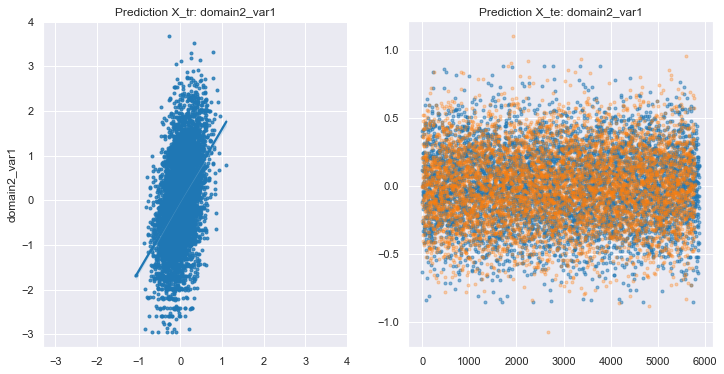

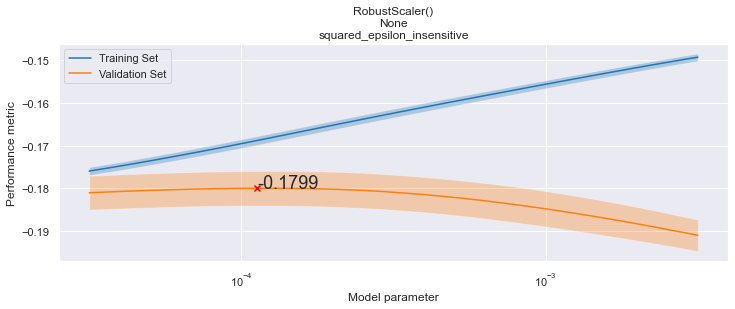

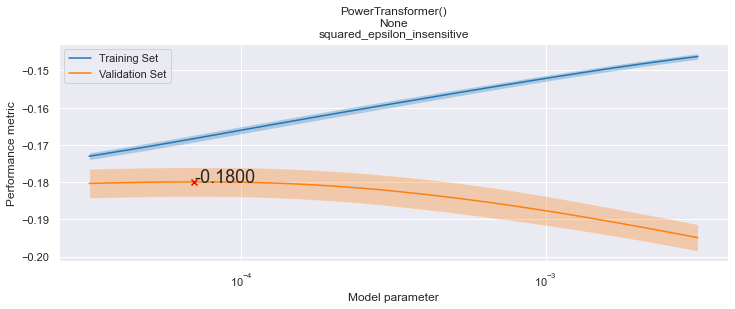

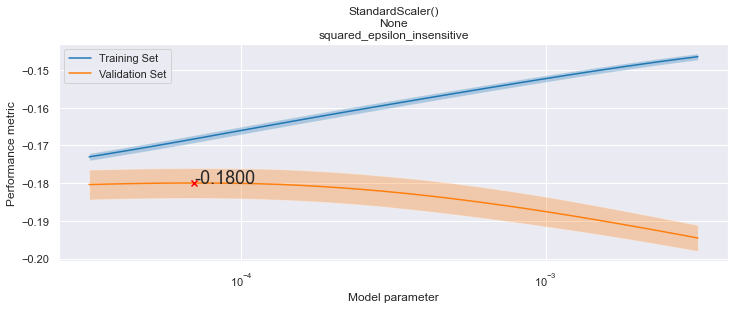

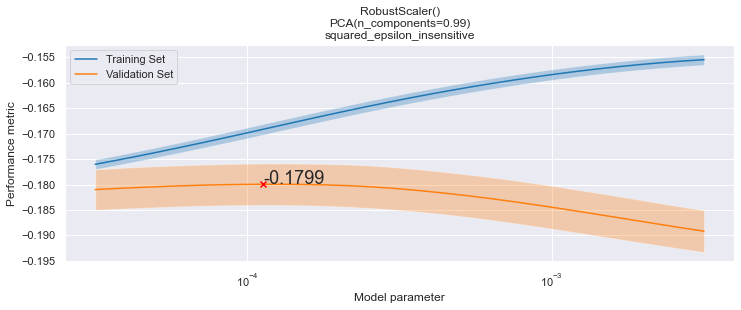

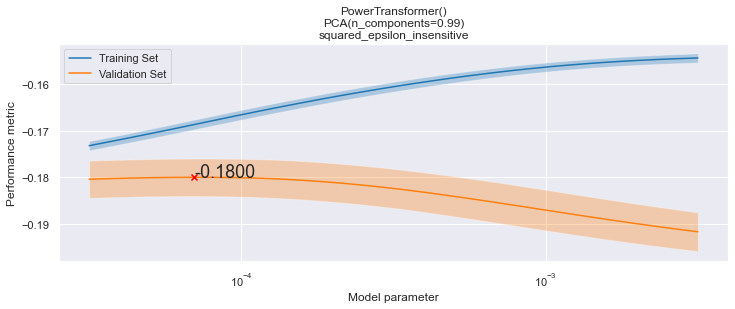

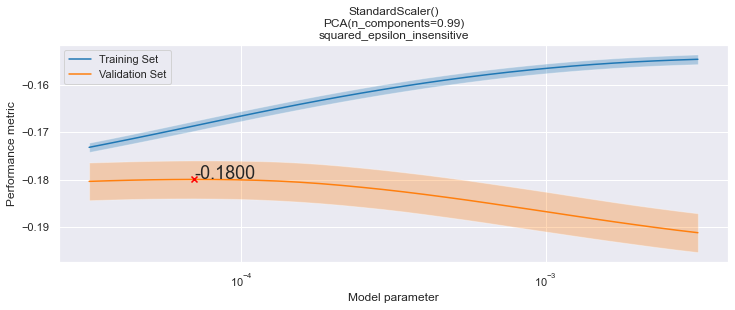

param_estimator__C        param_estimator__loss               param_pca  \
49        0.000112648  squared_epsilon_insensitive                    None   
52        0.000112648  squared_epsilon_insensitive  PCA(n_components=0.99)   
58        0.000132035  squared_epsilon_insensitive  PCA(n_components=0.99)   
32        6.99564e-05  squared_epsilon_insensitive                    None   
55        0.000132035  squared_epsilon_insensitive                    None   
38        8.19961e-05  squared_epsilon_insensitive                    None   
26        5.96846e-05  squared_epsilon_insensitive                    None   
30        6.99564e-05  squared_epsilon_insensitive                    None   
35        6.99564e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
43        9.61078e-05  squared_epsilon_insensitive                    None   

          param_scaler  mean_test_score  std_test_score  mean_train_score  \
49      RobustScaler()        -0.179946        0.004039         -0.168777   
52      RobustScaler()        -0.179948        0.004068         -0.169141   
58      RobustScaler()        -0.179950        0.004081         -0.168216   
32  PowerTransformer()        -0.179952        0.003967         -0.168315   
55      RobustScaler()        -0.179954        0.004051         -0.167788   
38  PowerTransformer()        -0.179961        0.003971         -0.167310   
26  PowerTransformer()        -0.179971        0.003964         -0.169305   
30    StandardScaler()        -0.179971        0.003980         -0.168288   
35  PowerTransformer()        -0.179974        0.003999         -0.168723   
43      RobustScaler()        -0.179980        0.004031         -0.169754   

    std_train_score  
49         0.001032  
52         0.001051  
58         0.001061  
32         0.001013  
55         0.001039  
38         0.001017  
26         0.001003  
30         0.001026  
35         0.001033  
43         0.001020

Starting with dataset short_merge - target: domain2_var2
Removing 39 missing values from target dataset.
Size of dataset:  (5786, 1655)
Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed: 13.2min finished


Best: -0.173348 using {'estimator__C': 9.610779662375913e-05, 'estimator__loss': 'squared_epsilon_insensitive', 'pca': PCA(n_components=0.99), 'scaler': RobustScaler()}


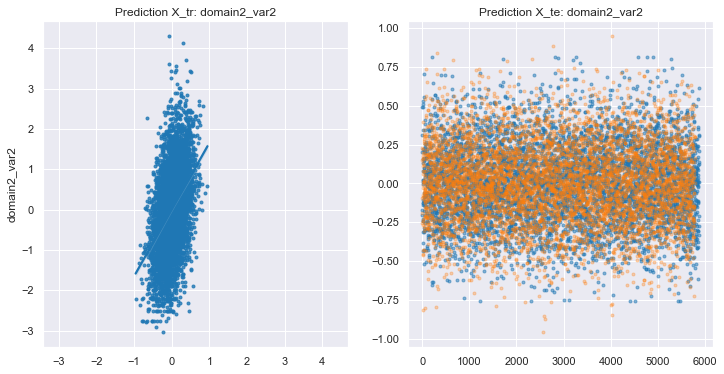

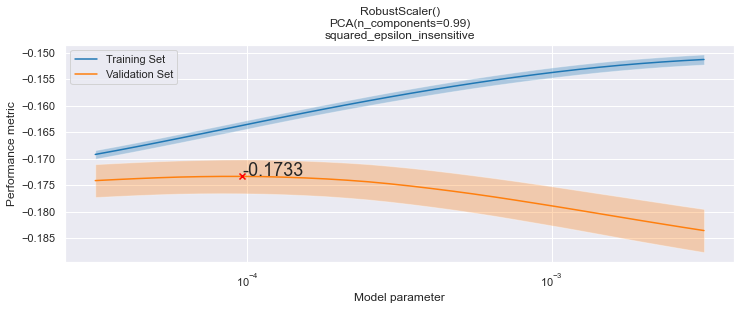

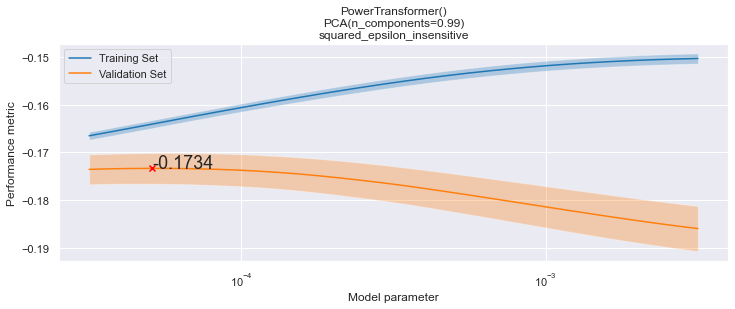

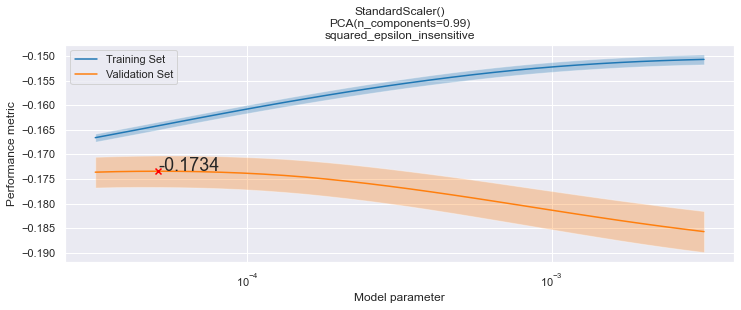

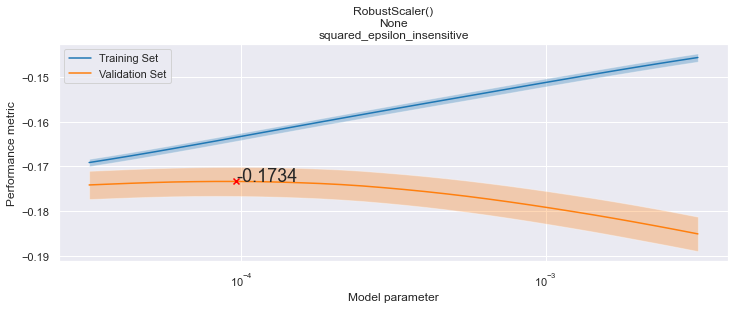

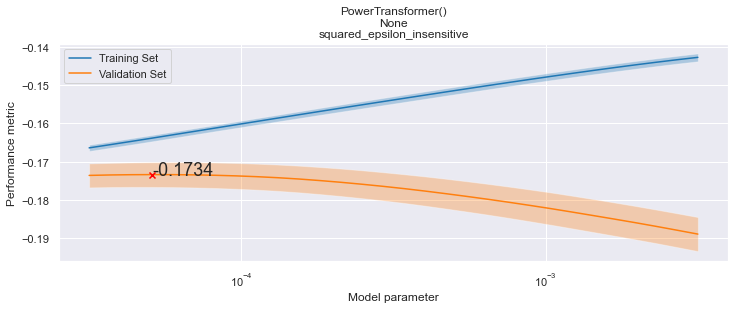

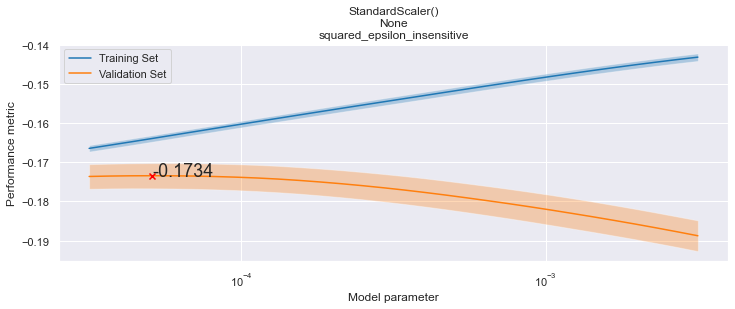

param_estimator__C        param_estimator__loss               param_pca  \
46        9.61078e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
40        8.19961e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
43        9.61078e-05  squared_epsilon_insensitive                    None   
37        8.19961e-05  squared_epsilon_insensitive                    None   
20         5.0921e-05  squared_epsilon_insensitive                    None   
23         5.0921e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
52        0.000112648  squared_epsilon_insensitive  PCA(n_components=0.99)   
26        5.96846e-05  squared_epsilon_insensitive                    None   
29        5.96846e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   
34        6.99564e-05  squared_epsilon_insensitive  PCA(n_components=0.99)   

          param_scaler  mean_test_score  std_test_score  mean_train_score  \
46      RobustScaler()        -0.173348        0.003192         -0.163735   
40      RobustScaler()        -0.173350        0.003171         -0.164548   
43      RobustScaler()        -0.173365        0.003261         -0.163462   
37      RobustScaler()        -0.173366        0.003242         -0.164316   
20  PowerTransformer()        -0.173381        0.003226         -0.163836   
23  PowerTransformer()        -0.173382        0.003211         -0.164103   
52      RobustScaler()        -0.173388        0.003212         -0.162927   
26  PowerTransformer()        -0.173389        0.003258         -0.162959   
29  PowerTransformer()        -0.173393        0.003246         -0.163273   
34      RobustScaler()        -0.173394        0.003147         -0.165354   

    std_train_score  
46         0.000811  
40         0.000812  
43         0.000806  
37         0.000811  
20         0.000820  
23         0.000829  
52         0.000808  
26         0.000818  
29         0.000828  
34         0.000812

score  estimator__C              estimator__loss  \
0  0.143927      0.000551  squared_epsilon_insensitive   
1  0.150053      0.000082  squared_epsilon_insensitive   
2  0.147735      0.000113  squared_epsilon_insensitive   
3  0.179946      0.000113  squared_epsilon_insensitive   
4  0.173348      0.000096  squared_epsilon_insensitive   

                      pca              scaler  
0                    None  PowerTransformer()  
1  PCA(n_components=0.99)  PowerTransformer()  
2                    None      RobustScaler()  
3                    None      RobustScaler()  
4  PCA(n_components=0.99)      RobustScaler()

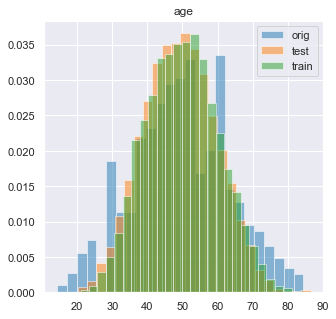

/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/mnotter/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


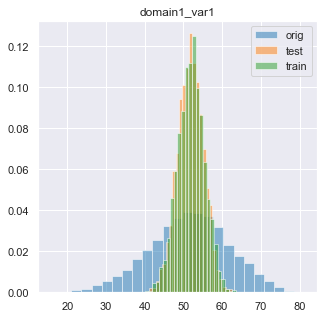

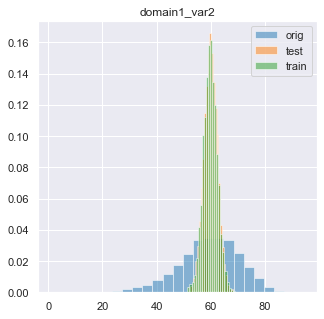

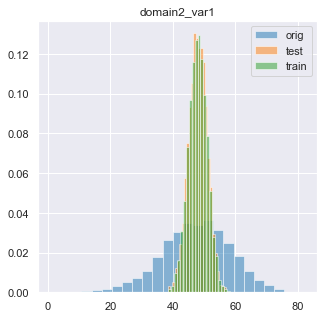

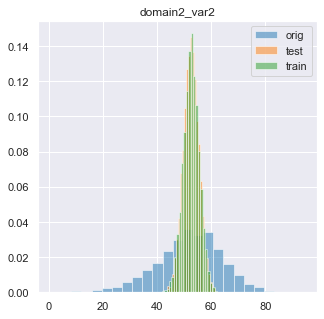

Score: 0.1571 | -0.1439 -0.1501 -0.1477 -0.1799 -0.1733


In [20]:
datasets_to_check = ['short_merge']

for dataset_id in datasets_to_check:

    predictions = {}
    scores = []
    grids = []

    for tidx, target in enumerate(['age', 'domain1_var1', 'domain1_var2', 'domain2_var1', 'domain2_var2']):

        print('Starting with dataset %s - target: %s' % (dataset_id, target))
        estimator = LinearSVR()
        df_pred, pred_tr, pred_te, grid, idx = run_prediction(model_metric,
            dataset_id=dataset_id, target=target, estimator=estimator,
            scaler_targets=scaler_targets, tidx=tidx)
        
        display_grid_optimization_details(grid)

        predictions['%s_tr' % target] = pred_tr
        predictions['%s_te' % target] = pred_te
        predictions['%s_miss' % target] = idx
        
        scores.append(grid.best_score_)
        grids.append(grid)

    # Display grids summary
    grids_summary(grids)
    
    # Compute overall score
    weights = [.3, .175, .175, .175, .175]
    score = np.sum([-s * weights[i] for i, s in enumerate(scores)])
    score_postfix = [int(score*10000)] + [-int(s*10000) for i, s in enumerate(scores)]

    df_results_tr, df_results_te = save_results(
        predictions, scaler_targets, targets, test_id, feature_transform,
        sample_submission, dataset_id, score_postfix)

    plot_prediction_distributions(targets, scaler_targets, df_results_tr, df_results_te)
    
    # Feedback of overall score
    txt = 'Score: {:.4f} | {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}'.format(score, *scores)
    print(txt)